# Packages import

In [ ]:
! python -m spacy download sl_core_news_sm

In [1]:
import os
import chardet
import spacy
from spacy.lang.sl import Slovenian
import gensim
from gensim import corpora
from gensim import models
import logging
import matplotlib.pyplot as plt
import pandas as pd

# Reading data

In [ ]:
def read_texts(
        path_to_dir : str
) -> list[dict]:
    """
    Reads texts from the directory taking into account their encodings
    """
    # Getting file names
    all_texts_names = sorted(os.listdir(path_to_dir))
    all_texts_paths = [
        f"{path_to_dir}/{dir}" for dir in all_texts_names
    ]
    all_texts = []

    # Reading and decoding files
    for text_name, text_path in zip(all_texts_names, all_texts_paths):
        with open(text_path, "rb") as file:
            raw = file.read()
            an_encoding = chardet.detect(raw)

            if an_encoding["encoding"] == "utf-8":
                current_encoding = an_encoding["encoding"]
                text = raw.decode(an_encoding["encoding"])
            else:
                current_encoding = "iso-8859-2"
                text = raw.decode(current_encoding)

            dict_ = {
                "file_name": text_name,
                "full_path": text_path,
                "encoding": current_encoding,
                "text": text
            }
            all_texts.append(dict_)
            

    return all_texts

In [ ]:
all_texts = read_texts("corpus")

## Searching for texts with the encodings different from "utf-8"

In [ ]:
def find_other_encodings(
        all_texts : list[dict]
) -> list[dict]:
    """
    Finds texts with the encodings different from 'utf-8'
    """
    texts_with_other_encodings = []
    for text in all_texts:
        if text["encoding"] != "utf-8":
            texts_with_other_encodings.append(text)

    return texts_with_other_encodings

In [8]:
texts_with_other_encodings = find_other_encodings(all_texts)

Total number of texts with other encodings:

In [9]:
len(texts_with_other_encodings)

5

Texts authors and texts names that cannot be properly decoded:

In [32]:
text_names_with_other_encodings = [
    text["file_name"]
    for text in texts_with_other_encodings
]
text_names_with_other_encodings

['Zofka Kveder - Moja prijateljica.txt',
 'Zofka Kveder - Na kmetih.txt',
 'Zofka Kveder - Telegrafistka.txt',
 'Zofka Kveder - Vaški roman.txt',
 'Zofka Kveder - Študentke.txt']

# Lemmatizing texts

We can lemmatize texts using spacy library and its module for Slovenian language:

In [39]:
nlp = spacy.load("sl_core_news_sm")
nlp.max_length = 5000000

In [34]:
def lemmatize_text(
        nlp: Slovenian,
        text: str
):
    """
    Lemmatizes slovenian text
    """
    doc = nlp(text)
    lemmas = []

    for token in doc:
        if not token.is_stop and not token.is_punct and "\n" not in token.lemma_:
            lemmas.append(token.lemma_.lower())

    return lemmas

In [35]:
lemmas = lemmatize_text(nlp, all_texts[0]["text"])

In [36]:
def save_lemmas(
        lemmas: list[str],
        dir_name: str,
        file_name: str
) -> None:
    """
    Saves lemmatized text
    """
    all_lemmas = " ".join(lemmas)
    with open(f"{dir_name}/{file_name}", "w", encoding="utf-8") as file:
        file.write(all_lemmas)

In [40]:
def lemmatize_all_texts(
        nlp,
        all_texts : list[dict],
        text_names_with_other_encodings: list[str]
):
    """
    Lemmatizes and saves all texts
    """
    dir_name = "lemmatized_corpus"
    os.makedirs(dir_name, exist_ok=True)

    existing_files = set(os.listdir(dir_name))

    all_lemmatized_texts = []
    for text in all_texts:
        
        if text["file_name"] in text_names_with_other_encodings:
            continue
        if text["file_name"] in existing_files:
            continue
        
        lemmas = lemmatize_text(nlp, text["text"])
        save_lemmas(lemmas, dir_name, text["file_name"])
        dict_ = {
            "file_name": text["file_name"],
            "lemmas": lemmas
        }
        all_lemmatized_texts.append(dict_)

    return all_lemmatized_texts

In [41]:
all_lemmatized_texts = lemmatize_all_texts(nlp, all_texts, text_names_with_other_encodings)

In [2]:
def read_lemmatized_texts(
    dir_with_lemmatized_texts: str
) -> dict:
    """
    Reads lemmatized texts
    """
    all_texts_names = sorted(os.listdir(dir_with_lemmatized_texts))
    all_texts_paths = [
        f"{dir_with_lemmatized_texts}/{dir}" for dir in all_texts_names
    ]
    all_lemmatized_texts = []

    for text_path, text_name in zip(all_texts_paths, all_texts_names):
        with open(text_path, "r", encoding="utf-8") as file:
            lemmas_text = file.read()
        dict_ = {
            "file_name": text_name,
            "lemmas": lemmas_text.split()
        }
        all_lemmatized_texts.append(dict_)
    return all_lemmatized_texts

In [3]:
all_lemmatized_texts = read_lemmatized_texts("lemmatized_corpus")

# Gensim preprocessing for LDA

In order to create an LDA model using gensim package, one needs to create Gensim corpus.

## Gensim Corpora

To create a Gensim corpus, we need to get a list with the lists of lemmas.

In [4]:
docs = [lemmatized_text["lemmas"] for lemmatized_text in all_lemmatized_texts]

We also get the dictionary where every word receives its id.

It is also important to filter extremes. For example, here down below we remove the words with too low or too high frequency. That is, they will be preserved in the sample if they occur at least in 5 documents (docs) and they are present in only 90% of the documents.

In [5]:
id2word = corpora.Dictionary(docs)
print(f"The size of the dictionary before filtering: {len(id2word)} lemmas")

id2word.filter_extremes(no_below=5,
                        no_above=0.9)
print(f"The size of the dictionary after filtering: {len(id2word)} lemmas")

The size of the dictionary before filtering: 207516 lemmas
The size of the dictionary after filtering: 43862 lemmas


Let's look at the example. We can get the id of a certain word:

In [6]:
lemma = "mrak"
print(f"Id for '{lemma}': {id2word.token2id[lemma]}")

Id for 'mrak': 1306


In [7]:
print(f"Lemma for id {1306}: {id2word[1306]}")

Lemma for id 1306: mrak


## Gensim Bag-Of-Words

Now we can proceed to creating bag of words for our documents. Bag of words is the collection of words with their frequencies. In BOW, every document is the list of tuples where the first value is the id of the word (from id2word) and the second value is the frequency of the word in the text. 

In [8]:
corpus = [id2word.doc2bow(doc) for doc in docs]

Let's look at the example. Below, you can see the first five words and their frequencies in the first document:

In [9]:
corpus[0][:5]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 3)]

## Gensim LDA Model

We can proceed to finally creating the LDA model.

Here we create a simple model with some random parameters.

In [73]:
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=20,
    random_state=100,
    passes=5,
    update_every=1,
    chunksize=500,
    alpha='auto',
    per_word_topics=True)

Let's look at the topics we got:

In [74]:
print(lda_model.print_topics(num_topics=-1, num_words=10))

[(0, '0.009*"kateri" + 0.006*"zopet" + 0.005*"boda" + 0.004*"ako" + 0.003*"takó" + 0.003*"dejati" + 0.003*"nega" + 0.003*"vender" + 0.003*"kakó" + 0.003*"jeden"'), (1, '0.017*"sim" + 0.012*"s." + 0.010*"de" + 0.005*"angel" + 0.004*"vender" + 0.003*"viditi" + 0.003*"ako" + 0.003*"bogu" + 0.003*"greh" + 0.003*"učiti"'), (2, '0.006*"zopet" + 0.004*"ktera" + 0.004*"ako" + 0.003*"grad" + 0.003*"kateri" + 0.003*"vojska" + 0.002*"boda" + 0.002*"kmet" + 0.002*"jej" + 0.002*"konj"'), (3, '0.015*"de" + 0.005*"ako" + 0.005*"jezus" + 0.004*"greh" + 0.003*"kateri" + 0.003*"vera" + 0.003*"mirko" + 0.003*"smert" + 0.003*"ampak" + 0.003*"bogu"'), (4, '0.005*"zopet" + 0.004*"kateri" + 0.003*"dejati" + 0.002*"ako" + 0.002*"hip" + 0.002*"tomaž" + 0.002*"župnik" + 0.002*"dvigniti" + 0.002*"takrat" + 0.002*"konj"'), (5, '0.009*"jurij" + 0.006*"kateri" + 0.006*"glavar" + 0.005*"zopet" + 0.004*"amalija" + 0.004*"deklica" + 0.004*"tolovaj" + 0.003*"jeden" + 0.003*"francka" + 0.002*"milica"'), (6, '0.011*"kate

### LDA Model. Coherence

In the previous chunks, we randomly chose the number of topics. However, this number can be adjusted using the Coherence metric.

*"Coherence measures the degree of semantic similarity between the top N words in each topic. Higher coherence scores indicate better topic quality. You can calculate coherence using the CoherenceModel class in gensim."* (sourse: https://www.kaggle.com/code/jrreda/gensim-lda-topic-modeling)

In [ ]:
# function that returns coherence values for different numbers of topics with the certain step
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute coherence values for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                passes = 5,
                                                chunksize=500,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [77]:
# for gensim to output some progress information while it's training
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [78]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=docs, start=10, limit=50, step=5)

2026-02-01 22:31:02,495 : INFO : using autotuned alpha, starting with [np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1), np.float32(0.1)]
2026-02-01 22:31:02,496 : INFO : using symmetric eta at 0.1
2026-02-01 22:31:02,502 : INFO : using serial LDA version on this node
2026-02-01 22:31:02,537 : INFO : running online (multi-pass) LDA training, 10 topics, 5 passes over the supplied corpus of 305 documents, updating model once every 305 documents, evaluating perplexity every 305 documents, iterating 50x with a convergence threshold of 0.001000
2026-02-01 22:31:02,538 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2026-02-01 22:31:05,826 : INFO : -11.334 per-word bound, 2581.1 perplexity estimate based on a held-out corpus of 305 documents with 3921955 words
2026-02-01 22:31:05,827 : INFO : PROGRESS: pass

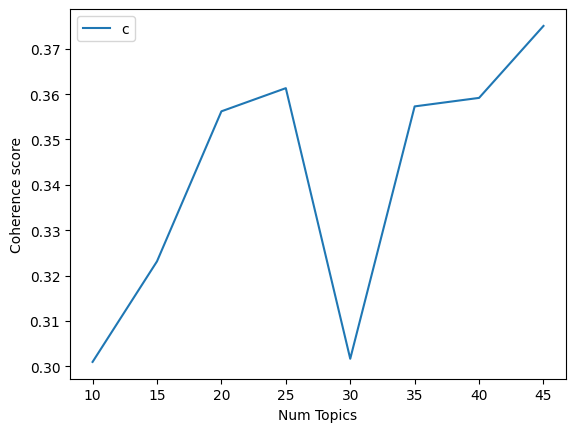

In [80]:
limit=50; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

We can observe the highest coherence if the number of topics is 25.

In [81]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.3009
Num Topics = 15  has Coherence Value of 0.3231
Num Topics = 20  has Coherence Value of 0.3562
Num Topics = 25  has Coherence Value of 0.3613
Num Topics = 30  has Coherence Value of 0.3016
Num Topics = 35  has Coherence Value of 0.3573
Num Topics = 40  has Coherence Value of 0.3592
Num Topics = 45  has Coherence Value of 0.375


The model's index with the highest coherence value is 3.

In [82]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(-1, num_words=10))
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))

2026-02-01 22:41:48,563 : INFO : topic #0 (0.078): 0.010*"kateri" + 0.006*"boda" + 0.005*"zopet" + 0.004*"ako" + 0.003*"nega" + 0.003*"takó" + 0.003*"vender" + 0.003*"dejati" + 0.003*"jeden" + 0.003*"kakó"
2026-02-01 22:41:48,564 : INFO : topic #1 (0.037): 0.007*"mravlja" + 0.006*"veseljak" + 0.005*"zopet" + 0.004*"ako" + 0.004*"grabež" + 0.003*"nega" + 0.003*"kateri" + 0.003*"marko" + 0.002*"jernej" + 0.002*"ktera"
2026-02-01 22:41:48,565 : INFO : topic #2 (0.070): 0.006*"ktera" + 0.006*"zopet" + 0.004*"ako" + 0.003*"jej" + 0.002*"kedar" + 0.002*"boda" + 0.002*"kteri" + 0.002*"toraj" + 0.002*"grad" + 0.002*"slovenski"
2026-02-01 22:41:48,566 : INFO : topic #3 (0.050): 0.006*"kateri" + 0.004*"zopet" + 0.004*"mirko" + 0.004*"ako" + 0.003*"grad" + 0.003*"boda" + 0.003*"grajščak" + 0.002*"ní" + 0.002*"angela" + 0.002*"jej"
2026-02-01 22:41:48,568 : INFO : topic #4 (0.135): 0.005*"zopet" + 0.004*"kateri" + 0.003*"dejati" + 0.003*"ako" + 0.002*"hip" + 0.002*"župnik" + 0.002*"tomaž" + 0.002*

[(0, '0.010*"kateri" + 0.006*"boda" + 0.005*"zopet" + 0.004*"ako" + 0.003*"nega" + 0.003*"takó" + 0.003*"vender" + 0.003*"dejati" + 0.003*"jeden" + 0.003*"kakó"'), (1, '0.007*"mravlja" + 0.006*"veseljak" + 0.005*"zopet" + 0.004*"ako" + 0.004*"grabež" + 0.003*"nega" + 0.003*"kateri" + 0.003*"marko" + 0.002*"jernej" + 0.002*"ktera"'), (2, '0.006*"ktera" + 0.006*"zopet" + 0.004*"ako" + 0.003*"jej" + 0.002*"kedar" + 0.002*"boda" + 0.002*"kteri" + 0.002*"toraj" + 0.002*"grad" + 0.002*"slovenski"'), (3, '0.006*"kateri" + 0.004*"zopet" + 0.004*"mirko" + 0.004*"ako" + 0.003*"grad" + 0.003*"boda" + 0.003*"grajščak" + 0.002*"ní" + 0.002*"angela" + 0.002*"jej"'), (4, '0.005*"zopet" + 0.004*"kateri" + 0.003*"dejati" + 0.003*"ako" + 0.002*"hip" + 0.002*"župnik" + 0.002*"tomaž" + 0.002*"takrat" + 0.002*"dvigniti" + 0.002*"nega"'), (5, '0.012*"jurij" + 0.007*"kateri" + 0.006*"glavar" + 0.005*"zopet" + 0.005*"deklica" + 0.005*"amalija" + 0.004*"tolovaj" + 0.004*"jeden" + 0.003*"milica" + 0.003*"tolova

2026-02-01 22:41:52,776 : INFO : -9.333 per-word bound, 644.9 perplexity estimate based on a held-out corpus of 305 documents with 3921955 words



Perplexity:  -9.332873498348576


Now we can see which topics correspond to which texts:

In [83]:
file_names = [lemmatized_text["file_name"] for lemmatized_text in all_lemmatized_texts]

In [84]:
topics = {
    "text_file_name": [],
    "topics": []
}

for file_name, doc in zip(file_names, docs):
    bow = id2word.doc2bow(doc)
    t = optimal_model.get_document_topics(bow)
    topics["text_file_name"].append(file_name)
    topics["topics"].append(t)

In [86]:
topics_df = pd.DataFrame.from_dict(topics)

In [87]:
topics_df

,text_file_name,topics
0,Albin Prepeluh - Mina.txt,"[(4, 0.8594189), (7, 0.12863556)]"
1,Alojz Kraigher - Kontrolor Škrobar.txt,"[(4, 0.2729827), (6, 0.45834467), (11, 0.09059..."
2,Alojz Kraigher - Mlada ljubezen.txt,"[(4, 0.08589058), (7, 0.0315119), (15, 0.70256..."
3,Alojzij Kokalj - Cerkvene miši.txt,"[(6, 0.9999537)]"
4,Alojzij Remec - Veliki punt.txt,"[(6, 0.109698966), (17, 0.059733395), (20, 0.8..."
...,...,...
300,Vladimir Levstik - V Babilonu svobode.txt,"[(4, 0.2909823), (15, 0.6998937)]"
301,Vladimir Levstik - Za svobodo in ljubezen.txt,"[(4, 0.16890274), (15, 0.05428235), (17, 0.775..."
302,Vladimir Levstik - Zapiski Tine Gramontove.txt,"[(4, 0.9130433), (8, 0.022673331), (15, 0.0511..."
303,Zofka Kveder - Nada.txt,"[(4, 0.7312605), (15, 0.25759378), (16, 0.0105..."


And the topics themselves:

In [88]:
optimal_model.show_topics(num_topics=25, formatted=False)

[(0,
  [('kateri', np.float32(0.010449026)),
   ('boda', np.float32(0.005596274)),
   ('zopet', np.float32(0.0052745226)),
   ('ako', np.float32(0.0038168582)),
   ('nega', np.float32(0.0033184)),
   ('takó', np.float32(0.0031881544)),
   ('vender', np.float32(0.0030671812)),
   ('dejati', np.float32(0.002755962)),
   ('jeden', np.float32(0.002726732)),
   ('kakó', np.float32(0.0026903))]),
 (1,
  [('mravlja', np.float32(0.006868925)),
   ('veseljak', np.float32(0.0056440835)),
   ('zopet', np.float32(0.004816796)),
   ('ako', np.float32(0.004291644)),
   ('grabež', np.float32(0.0037024277)),
   ('nega', np.float32(0.003246156)),
   ('kateri', np.float32(0.00281157)),
   ('marko', np.float32(0.0026361092)),
   ('jernej', np.float32(0.0024483409)),
   ('ktera', np.float32(0.0018288246))]),
 (2,
  [('ktera', np.float32(0.006067948)),
   ('zopet', np.float32(0.005896146)),
   ('ako', np.float32(0.0035622306)),
   ('jej', np.float32(0.0025308402)),
   ('kedar', np.float32(0.0021948928)),
 